Goal:

- show that our fitting procedure is robust to noise
- that an incorrect choice of initial parameters may give wrong results


In [1]:
from ANEMO import ANEMO
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lmfit
from lmfit import  Model, Parameters
lmfit.__version__

'0.9.10'

# Loading eye movement data

In [2]:
import pickle
with open('../demo/result/param_Fit_AM.pkl', 'rb') as fichier :
    param = pickle.load(fichier, encoding='latin1')
with open('../demo/data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')

# Creating a fitting procedure

In [3]:
def fit(x, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit, step_fit, bruit,
        TargetOn, StimulusOf, start_sac=770, stop_sac=820):

    np.random.seed(7)
    

    param_fit={'tau':tau_fit, 'maxi':maxi_fit, 'a_anti':a_anti_fit, 'latency':latency_fit,
               'start_anti':start_anti_fit}
    
    result_fit={'start_anti_true':[], 'start_anti_fit':[], 'a_anti_true':[], 'a_anti_fit':[],
                'latency_true':[], 'latency_fit':[], 'bino':[], 'test':[],
                'tau_true':[], 'tau_fit':[], 'maxi_true':[], 'maxi_fit':[],
                'old_latency':[],'old_max':[]}
    
    
    for trial in range(25):
        bino = exp['p'][trial][0][0]
        start_anti_true = param['start_anti'][0][trial]+TargetOn
        a_anti_true = param['a_anti'][0][trial]
        latency_true = param['latency'][0][trial]+TargetOn
        tau_true = param['tau'][0][trial]
        maxi_true = param['maxi'][0][trial]

        test = ANEMO.fct_velocity(x, bino, start_anti_true, a_anti_true, latency_true,
                                     tau_true, maxi_true)+np.random.rand(len(x))*bruit
        test = test-np.random.rand(len(x))*bruit
        test[start_sac:stop_sac] = np.arange(0, (stop_sac-start_sac), 1)*np.nan

        result_deg = ANEMO.Fit_velocity(test, x, bino, param_fit=param_fit, sup=None, step=step_fit)

        result_fit['test'].append(test)
        result_fit['bino'].append(bino)
        
        result_fit['start_anti_true'].append(start_anti_true)
        result_fit['a_anti_true'].append(a_anti_true)
        result_fit['latency_true'].append(latency_true)
        result_fit['tau_true'].append(tau_true)
        result_fit['maxi_true'].append(maxi_true)
        
        result_fit['start_anti_fit'].append(result_deg.values['start_anti'])
        result_fit['a_anti_fit'].append(result_deg.values['a_anti'])
        result_fit['latency_fit'].append(result_deg.values['latency'])
        result_fit['tau_fit'].append(result_deg.values['tau'])
        result_fit['maxi_fit'].append(result_deg.values['maxi'])
        
        StimulusOn = 0
        a, b = StimulusOn, StimulusOf
        c, seuil = TargetOn+100, 3
        lat = np.where(np.abs(test[c:]) > np.abs(np.nanmean(test[a:b]))+np.abs(np.nanstd(test[a:b])*seuil))
        old_latency = lat[0][0]+c
        result_fit['old_latency'].append(old_latency)
        
        
        a1, b1 = TargetOn+400, TargetOn+600
        maxmax = np.where(np.abs(test) > np.abs(np.nanmean(test[a1:b1])))
        old_max = np.abs(test[maxmax[0][0]])
        result_fit['old_max'].append(old_max)
            
    return result_fit

In [4]:
def regress(ax, p, data, t_label=12) :
    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    x_test = np.linspace(np.min(p), np.max(p), 100)
    fitLine = slope * x_test + intercept
    ax.plot(x_test, fitLine, c='k', linewidth=2)
    ax.text(min(p),max(data)-((max(data)-min(data))/10), 'r = %0.3f'%(r_), fontsize=t_label/1.2)

    return ax

In [5]:
def plot(x, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit, bruit, TargetOn, StimulusOf) :
    fig2, axs2 = plt.subplots(3, 2, figsize=(10*2, 3*(10*1/2)/1.6180))
    fig, axs = plt.subplots(5, 3, figsize=(5*3, (5*5)/1.6180))
    
    
    l = ['start_anti', 'a_anti','latency', 'tau', 'maxi']
    
    for a in range(2) :
        
        result_fit = fit(x, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit, a+1, bruit, TargetOn, StimulusOf)
        

        for b in range(5):
            axs[b][a].set_title('%s fit %s_step'%(l[b], a+1))
            axs[b][a].set_xlabel('%s_true'%l[b])
            axs[b][a].set_ylabel('%s_fit'%l[b])
            axs[b][a].plot([-2000, 2000], [-2000, 2000], '--r')
            
            axs[b][a].scatter(result_fit['%s_true'%l[b]], result_fit['%s_fit'%l[b]], c='k', alpha=0.5)
            axs[b][a] = regress(axs[b][a], result_fit['%s_true'%l[b]], result_fit['%s_fit'%l[b]])
            min_x, min_y = min(result_fit['%s_true'%l[b]]), min(result_fit['%s_fit'%l[b]])
            max_x, max_y = max(result_fit['%s_true'%l[b]]), max(result_fit['%s_fit'%l[b]])
            axs[b][a].axis([min_x-((max_x-min_x)/10), max_x+((max_x-min_x)/10),
                            min_y-((max_y-min_y)/10), max_y+((max_y-min_y)/10)])
        


  
        for trial in range(3) :
            if trial==0 :
                axs2[trial][a].set_title('Fit %s_step'%(a+1), fontsize=20)
            axs2[trial][a].set_xlabel('Time (ms)', fontsize=15)
            axs2[trial][a].set_ylabel('velocity (°/s)', fontsize=15)
            
            axs2[trial][a].plot(x, np.ones(len(x))*(result_fit['bino'][trial]*2-1)*result_fit['old_max'][trial])
            axs2[trial][a].bar(result_fit['old_latency'][trial], 80, bottom=-40, color='g', width=4, linewidth=0)

            
            axs2[trial][a].plot(result_fit['test'][trial], c='k', alpha=0.5)
            init_fit = ANEMO.fct_velocity(x, result_fit['bino'][trial], start_anti_fit[0], a_anti_fit[0],
                                             latency_fit[0], tau_fit[0], maxi_fit[0])
            best_fit = ANEMO.fct_velocity(x, result_fit['bino'][trial], result_fit['start_anti_fit'][trial], result_fit['a_anti_fit'][trial],
                                             result_fit['latency_fit'][trial], result_fit['tau_fit'][trial],
                                             result_fit['maxi_fit'][trial])

            axs2[trial][a].plot(init_fit, c='k')
            axs2[trial][a].plot(best_fit, c='r')
            
    axs[2][2].set_title('Old latency')
    axs[2][2].set_xlabel('latency_true')
    axs[2][2].set_ylabel('Old_latency')
    axs[2][2].plot([-2000, 2000], [-2000, 2000], '--r')

    axs[2][2].scatter(result_fit['latency_true'], result_fit['old_latency'], c='k', alpha=0.5)
    axs[2][2] = regress(axs[2][2], result_fit['latency_true'], result_fit['old_latency'])
    min_x, min_y = min(result_fit['latency_true']), min(result_fit['old_latency'])
    max_x, max_y = max(result_fit['latency_true']), max(result_fit['old_latency'])
    axs[2][2].axis([min_x-((max_x-min_x)/10), max_x+((max_x-min_x)/10),
                    min_y-((max_y-min_y)/10), max_y+((max_y-min_y)/10)])
    
    axs[4][2].set_title('Old Max')
    axs[4][2].set_xlabel('maxi_true')
    axs[4][2].set_ylabel('Old_Max')
    axs[4][2].plot([-2000, 2000], [-2000, 2000], '--r')

    axs[4][2].scatter(result_fit['maxi_true'], result_fit['old_max'], c='k', alpha=0.5)
    axs[4][2] = regress(axs[4][2], result_fit['maxi_true'], result_fit['old_max'])
    min_x, min_y = min(result_fit['maxi_true']), min(result_fit['old_max'])
    max_x, max_y = max(result_fit['maxi_true']), max(result_fit['old_max'])
    axs[4][2].axis([min_x-((max_x-min_x)/10), max_x+((max_x-min_x)/10),
                    min_y-((max_y-min_y)/10), max_y+((max_y-min_y)/10)])
            
    fig.tight_layout()
    fig2.tight_layout()

# Fitting using default parameters from ANEMO

In [6]:
x = np.arange(0, 1400, 1)
TargetOn, StimulusOf = 750, 750-300

In [7]:
def defaut():
    start_anti_fit = [TargetOn-100, StimulusOf-200, TargetOn+75]
    latency_fit = [TargetOn+100, TargetOn+75, len(x)]
    a_anti_fit = [0., -40., 40.]
    tau_fit = [15., 13., 80.]
    maxi_fit = [15., 1., 40.]

    return(start_anti_fit, latency_fit, a_anti_fit, tau_fit, maxi_fit)

/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


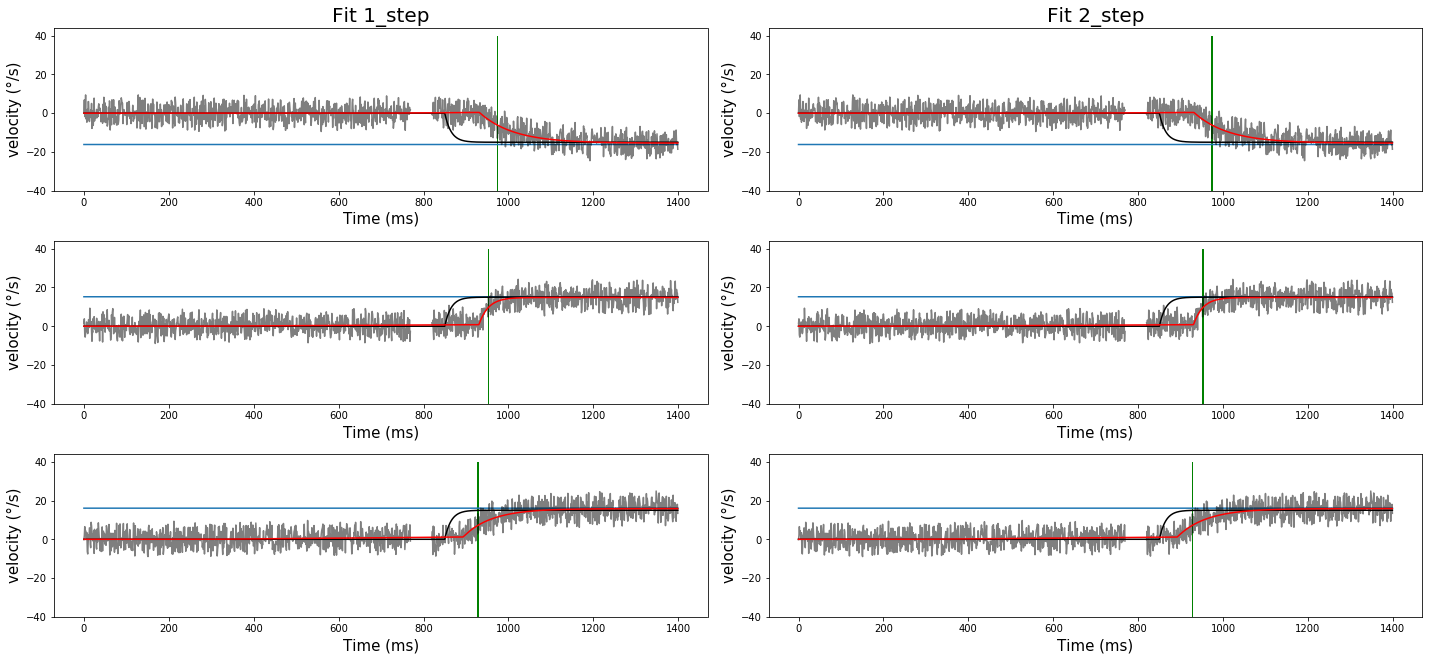

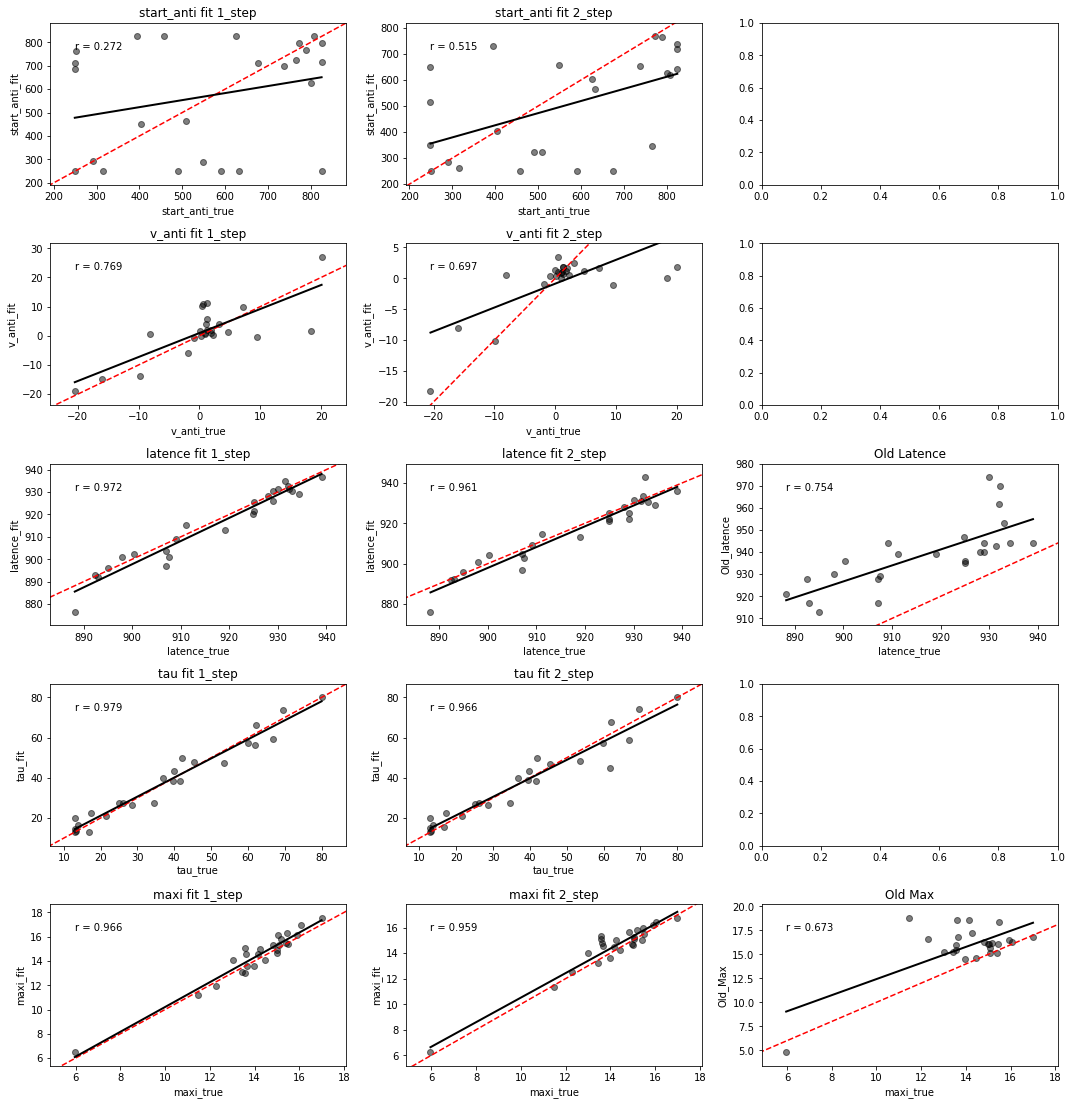

In [8]:
start_anti_fit, latency_fit, a_anti_fit, tau_fit, maxi_fit = defaut()

plot(x, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit, 10, TargetOn, StimulusOf)


# Fitting using abberrant parameters from ANEMO


 is a double fit procedure more robust?

### Maxi

/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


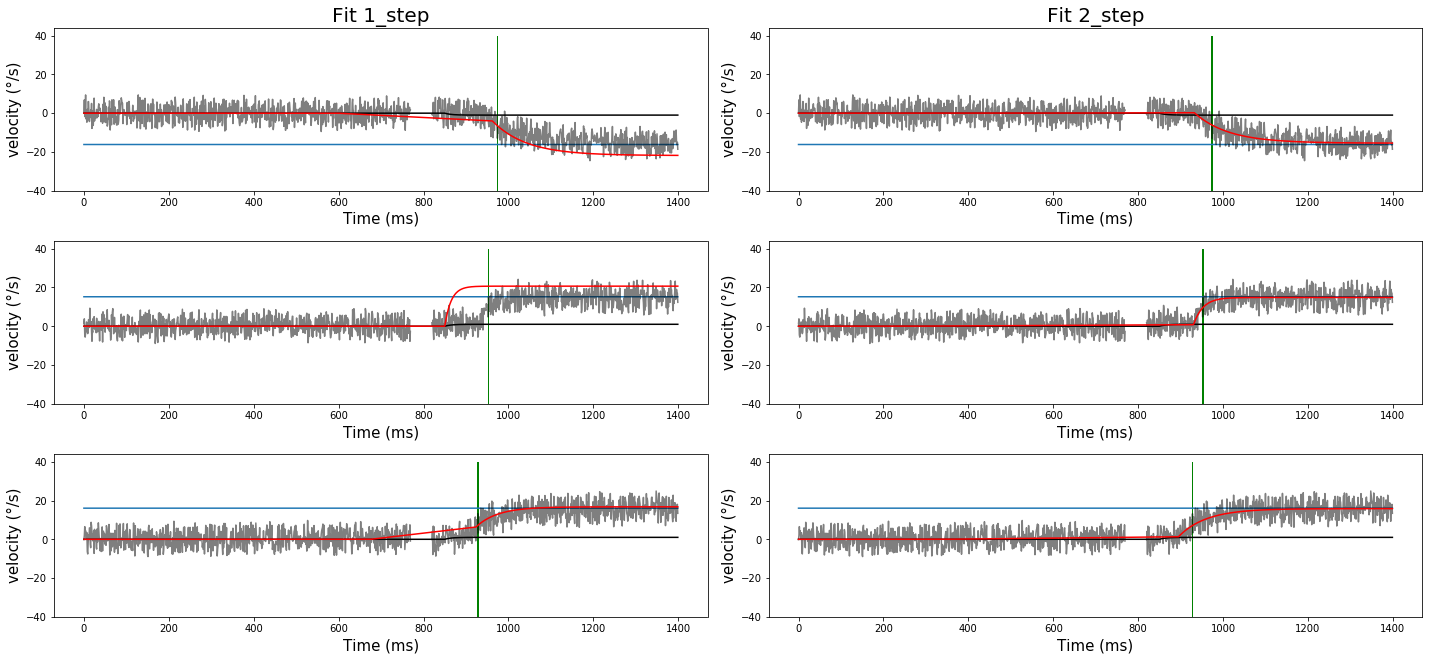

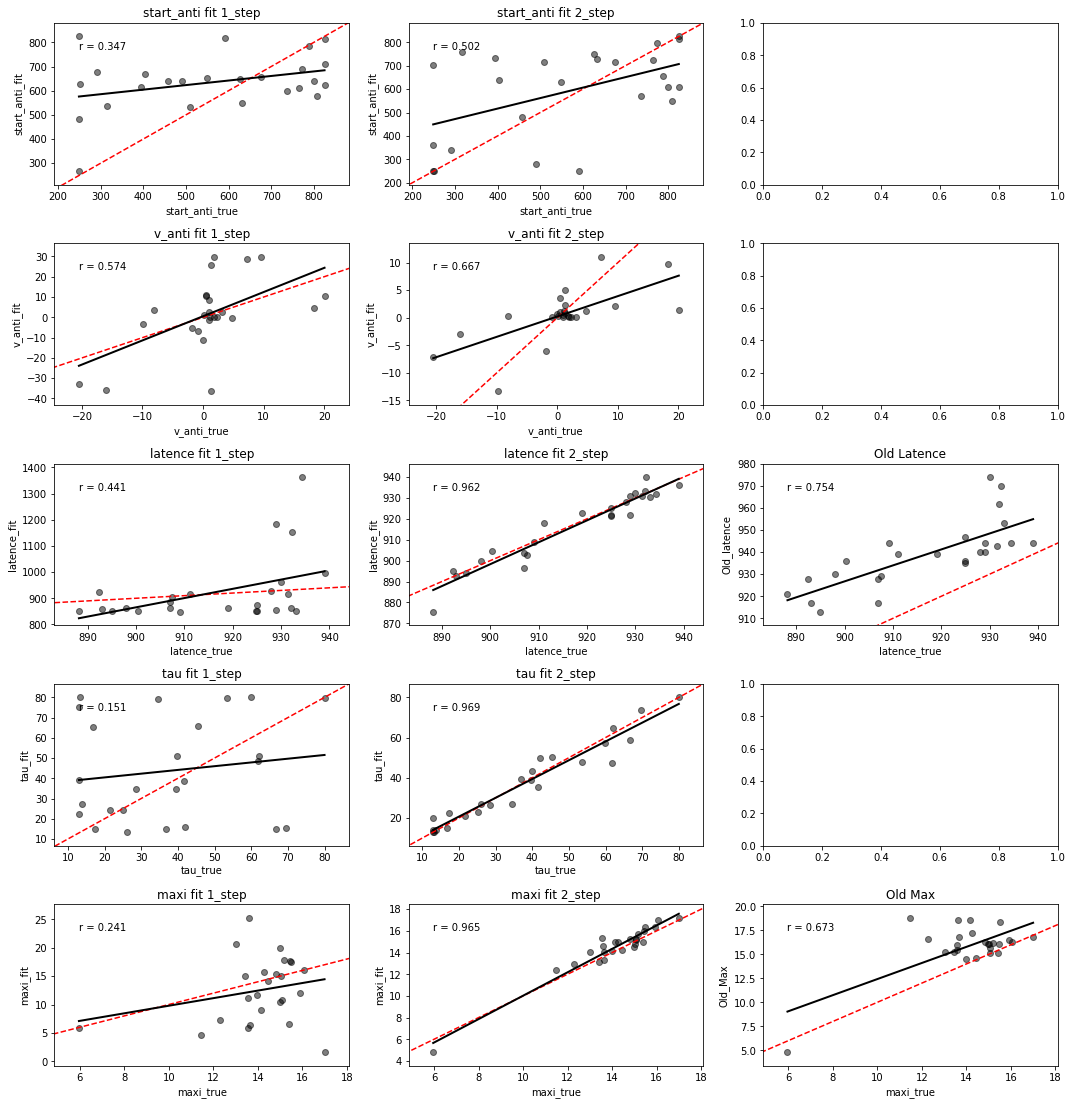

In [9]:
start_anti_fit, latency_fit, a_anti_fit, tau_fit, maxi_fit = defaut()
maxi_fit = [1., 1., 40.]  # [15., 1., 40.]

plot(x, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit, 10, TargetOn, StimulusOf)

### tau

/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


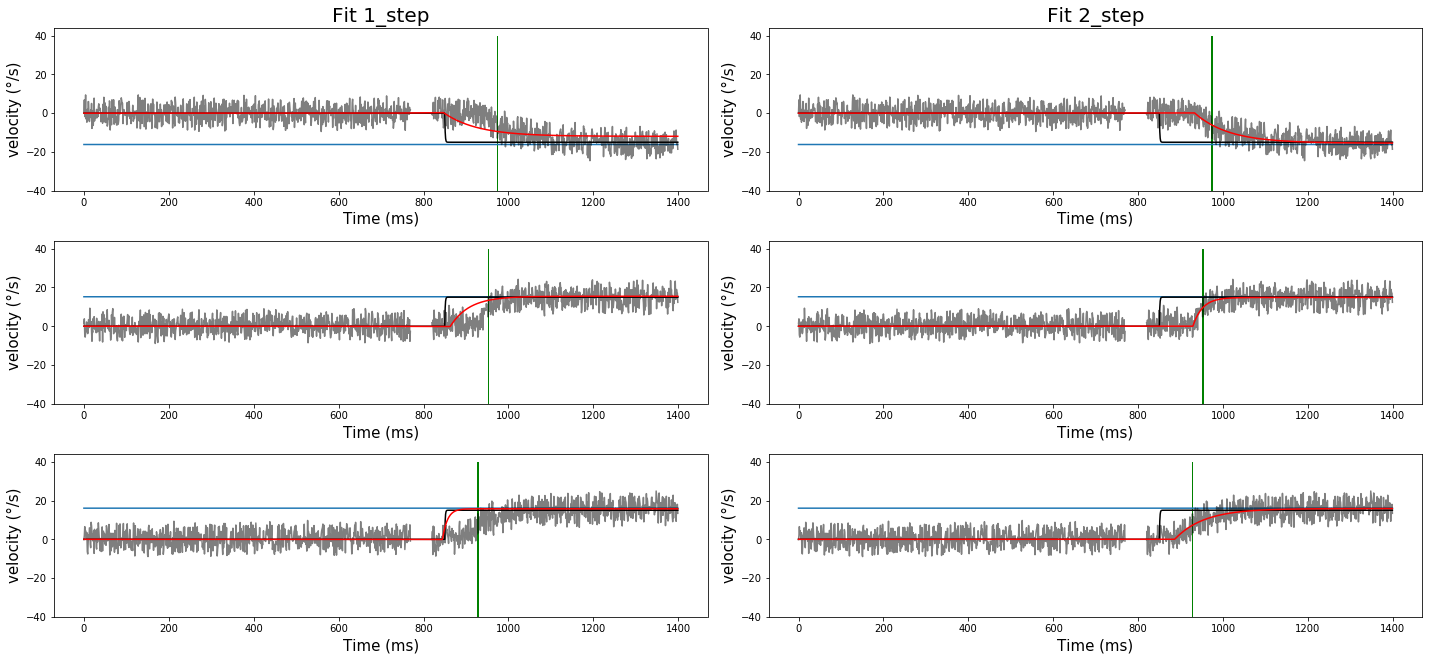

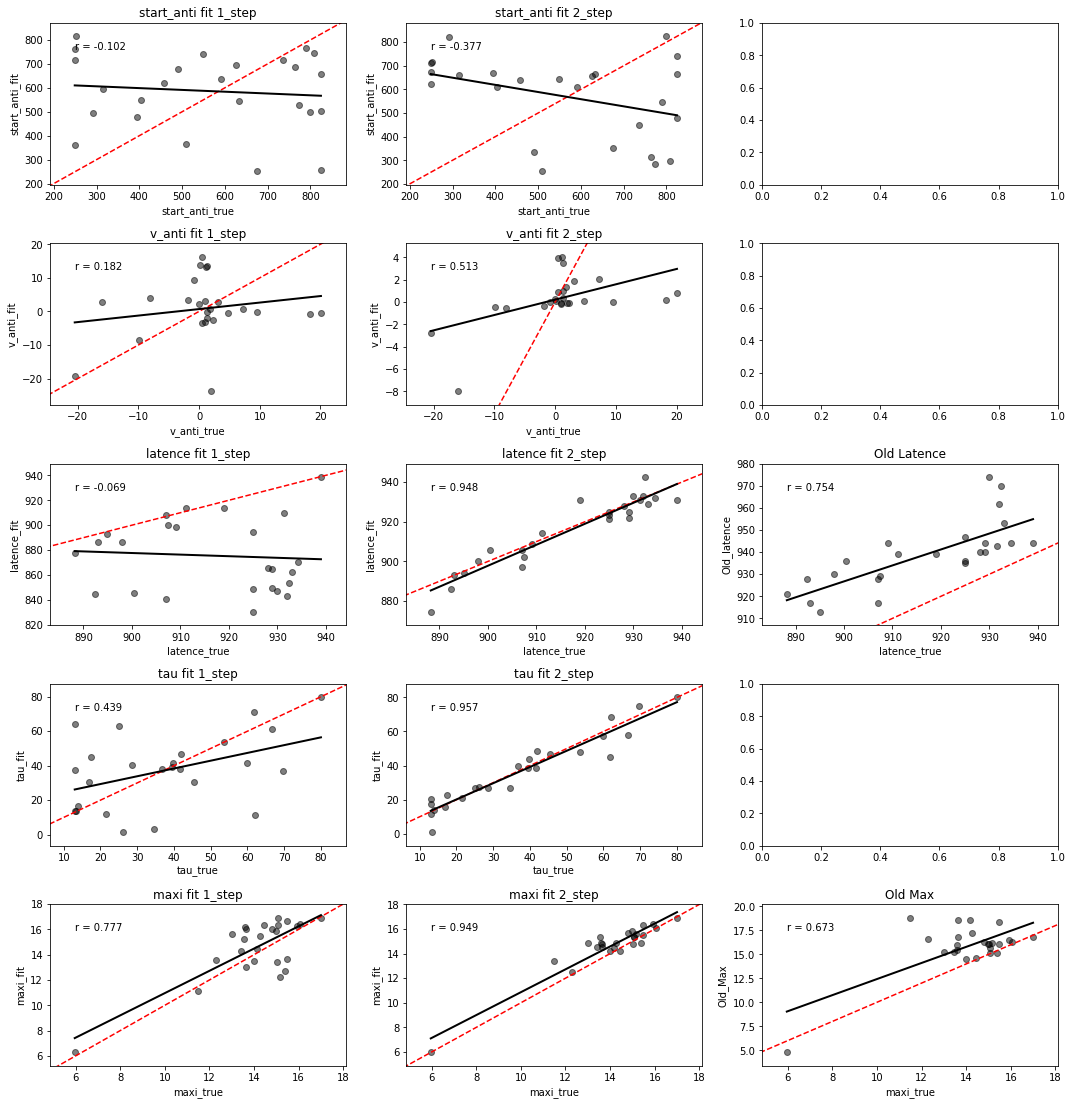

In [10]:
start_anti_fit, latency_fit, a_anti_fit, tau_fit, maxi_fit = defaut()
tau_fit = [1.,1.,80.] # [15.,13.,80.]

plot(x, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit, 10, TargetOn, StimulusOf)

### a_anti

/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


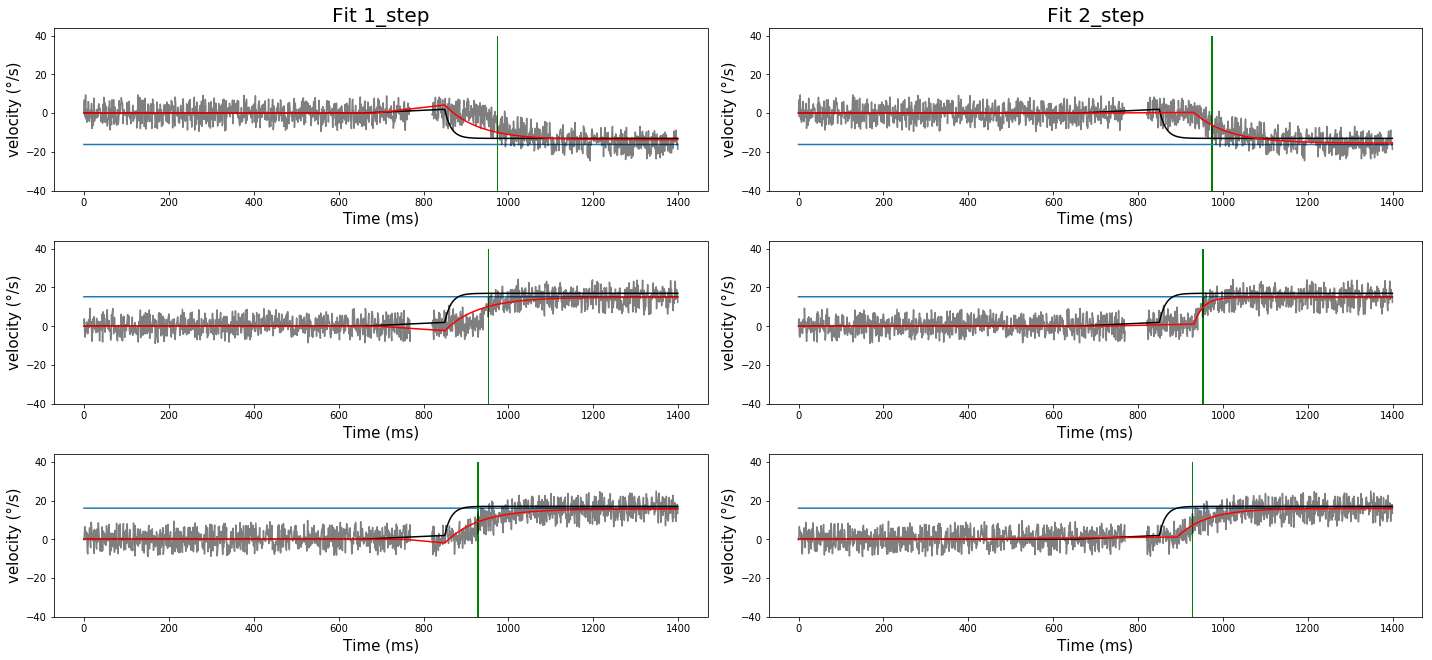

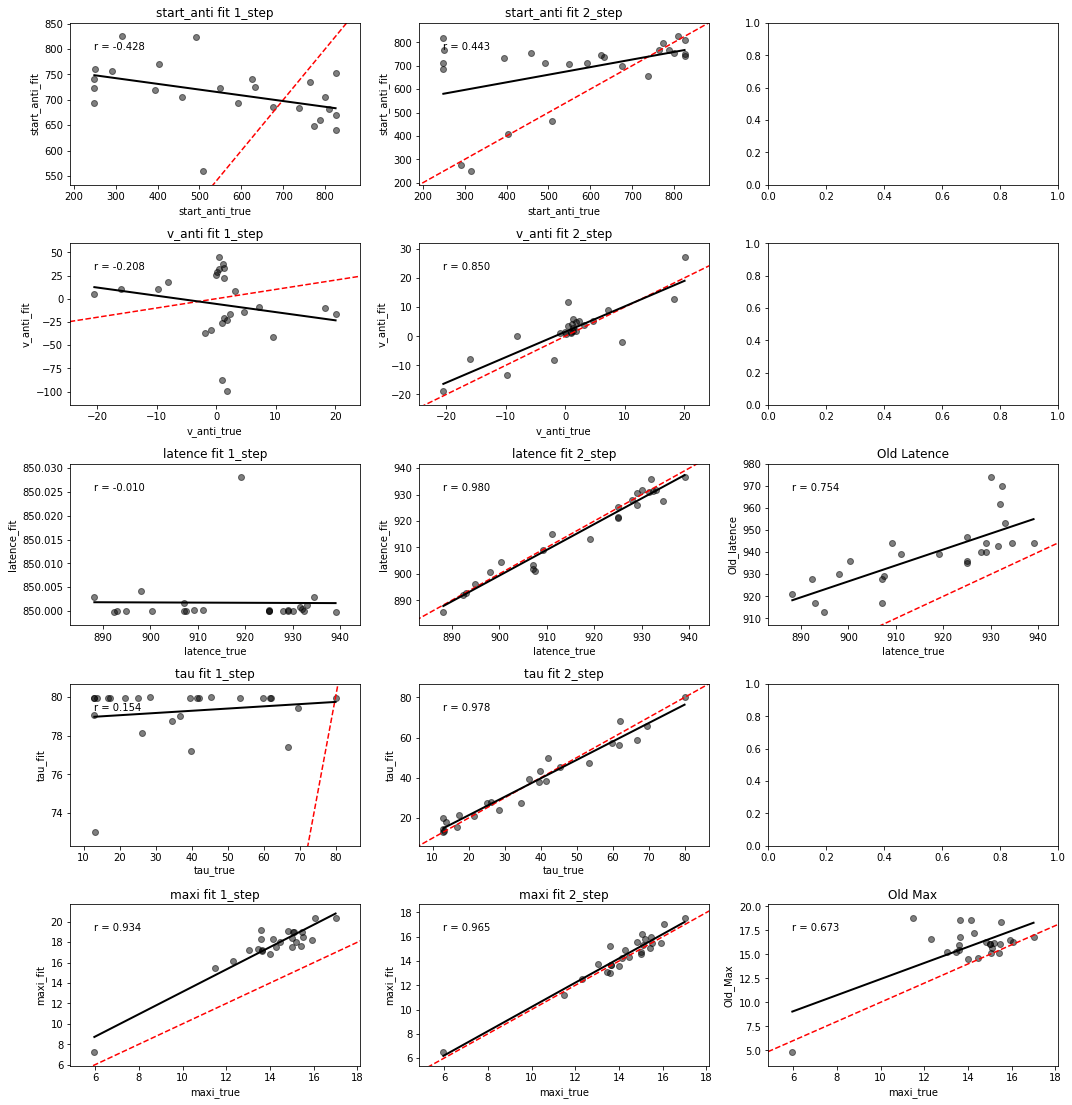

In [11]:
start_anti_fit, latency_fit, a_anti_fit, tau_fit, maxi_fit = defaut()
a_anti_fit = [10.,-100.,100.] # [0.,-40.,40.]

plot(x, start_anti_fit, a_anti_fit, latency_fit, tau_fit, maxi_fit, 10, TargetOn, StimulusOf)